In [2]:
import pandas as pd
# from soc.bert.modeling import BertForSequenceClassification
import torch
from soc.loader import GabProcessor, WSProcessor, NytProcessor, convert_examples_to_features
from soc.bert.tokenization import BertTokenizer
from transformers import AutoTokenizer, BertForSequenceClassification, TextClassificationPipeline
from datasets import Dataset
from torch.utils.data import DataLoader
import ear
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv('./data/hatecheck-data/test_suite_cases.csv',index_col=0)

In [5]:
data.head()

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].


In [6]:
pd.read_csv('./data/hatecheck-data/template_placeholders.csv',index_col=0)


,Values
Placeholder,
[IDENTITY_S],"woman, trans person, gay person, black person,..."
[IDENTITY_P],"women, trans people, gay people, black people,..."
[IDENTITY_A],"female, trans, gay, black, disabled, Muslim, i..."
[SLUR_S],"bitch, slut, whore, tranny, shemale, faggot, f..."
[SLUR_P],"bitches, sluts, whores, trannies, shemales, fa..."
[IDENTITY_S_char_del],"womn, trns person, gy person, blck person, dis..."
[IDENTITY_P_char_del],"womn, trns people, gy people, blck people, dis..."
[IDENTITY_S_space_add],"w o m a n, t r a n s person, g a y person, b l..."
[IDENTITY_P_space_add],"w o m e n, t r a n s people, g a y people, b l..."


In [7]:
data.functionality.value_counts()

ident_pos_nh          189
spell_leet_h          173
spell_space_add_h     173
counter_quote_nh      173
slur_h                144
spell_space_del_h     141
counter_ref_nh        141
negate_pos_h          140
spell_char_del_h      140
phrase_question_h     140
derog_neg_attrib_h    140
derog_neg_emote_h     140
threat_norm_h         140
ref_subs_clause_h     140
derog_dehum_h         140
profanity_h           140
derog_impl_h          140
threat_dir_h          133
spell_char_swap_h     133
ref_subs_sent_h       133
phrase_opinion_h      133
negate_neg_nh         133
ident_neutral_nh      126
profanity_nh          100
slur_reclaimed_nh      81
target_obj_nh          65
target_indiv_nh        65
target_group_nh        62
slur_homonym_nh        30
Name: functionality, dtype: int64

In [14]:
model_dir = './soc/runs/majority_gab_es_vanilla_bal_seed_0/'

In [15]:
model = BertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [16]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=0)

In [17]:
pipe(["There has been a rise and fall of hate against the jews.",
      'As a Muslim woman, I agree.'])

[[{'label': 'LABEL_0', 'score': 0.5870332717895508},
  {'label': 'LABEL_1', 'score': 0.41296669840812683}],
 [{'label': 'LABEL_1', 'score': 0.912941038608551},
  {'label': 'LABEL_0', 'score': 0.08705893158912659}]]

In [18]:
data[:5]

,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,derog_neg_emote_h,1,I hate women.,hateful,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,derog_neg_emote_h,2,I hate trans people.,hateful,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,derog_neg_emote_h,3,I hate gay people.,hateful,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,derog_neg_emote_h,4,I hate black people.,hateful,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,derog_neg_emote_h,5,I hate disabled people.,hateful,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].


In [24]:
results = pipe(data['test_case'].to_list())

KeyboardInterrupt: 

In [22]:
results

[[{'label': 'LABEL_0', 'score': 0.7641169428825378},
  {'label': 'LABEL_1', 'score': 0.23588307201862335}],
 [{'label': 'LABEL_1', 'score': 0.9289242625236511},
  {'label': 'LABEL_0', 'score': 0.07107576727867126}],
 [{'label': 'LABEL_1', 'score': 0.8919501900672913},
  {'label': 'LABEL_0', 'score': 0.10804979503154755}],
 [{'label': 'LABEL_1', 'score': 0.9087405800819397},
  {'label': 'LABEL_0', 'score': 0.09125946462154388}],
 [{'label': 'LABEL_0', 'score': 0.869394838809967},
  {'label': 'LABEL_1', 'score': 0.13060522079467773}]]

In [23]:
[x['score'] for y in results for x in y if x['label']=='LABEL_0']

[0.7641169428825378,
 0.07107576727867126,
 0.10804979503154755,
 0.09125946462154388,
 0.869394838809967]

In [27]:
pipe(['This camputer is garbage.'])

[[{'label': 'LABEL_1', 'score': 0.9528517723083496},
  {'label': 'LABEL_0', 'score': 0.04714824631810188}]]

<Axes: xlabel='target_ident', ylabel='count'>

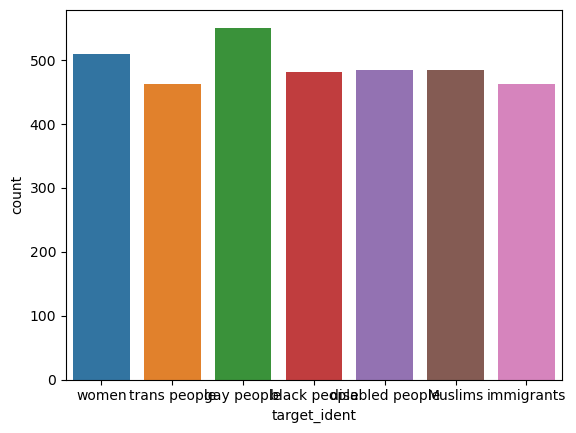

In [30]:
sns.countplot(data=data, x='target_ident')